In [2]:
import os 
import torch  
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import numpy as np
import matplotlib.pyplot as plt 

from torchvision import transforms
from modules import fpn 
from PIL import Image 
import pdb

# 0. Prepare helper functions.

In [3]:
class Args:
    def __init__(self):
        pass
    
def collate_eval(batch):
    indice = [b[0] for b in batch]
    image = torch.stack([b[1] for b in batch])
    if batch[0][-1] is not None:
        label = torch.stack([b[2] for b in batch])

        return indice, image, label
    else:
        return indice, image
    
def get_score_histogram(label_trues, label_preds, n_class):
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += fast_hist(lt.flatten(), lp.flatten(), n_class)
    
    return hist

def compute_dist(featmap, metric_function, euclidean_train=True):
    # pdb.set_trace()
    centroids = metric_function.module.weight.data
    if euclidean_train:
        return - (1 - 2*metric_function(featmap)\
                    + (centroids*centroids).sum(dim=1).unsqueeze(0)) # negative l2 squared 
    else:
        return metric_function(featmap)

preprocess = transforms.Compose([transforms.ToTensor(), 
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                      std=[0.229, 0.224, 0.225])])


In [4]:
args = Args()

# Model
args.pretrain = True 
args.ssl = False 
args.ssl_dir = False 
args.arch = 'resnet18'

# Classifier
args.in_dim = 128
args.K = 20

# Dataloader
args.data_root = ''

# 1. Load PiCIE.

**NOTE**: Place the COCO version of PiCIE weight at "picie.pkl" 

In [5]:
# picie_load = torch.load('picie.pkl', 'cpu')
picie_load = torch.load('/home/nano01/a/tao88/PiCIE-CelebA/results/picie_on_celeba_finetuned_model_coarse/train/1/augmented/res1=256_res2=512/jitter=True_blur=True_grey=True/equiv/h_flip=True_v_flip=False_crop=True/min_scale\=0.5/K_train=20_cosine/checkpoint_7.pth.tar', 'cpu')

model = fpn.PanopticFPN(args)
model = nn.DataParallel(model)
model.load_state_dict(picie_load['state_dict'])

classifier = nn.Conv2d(args.in_dim, args.K, kernel_size=1, stride=1, padding=0, bias=True)
classifier = nn.DataParallel(classifier)
classifier.load_state_dict(picie_load['classifier1_state_dict'])

# Important ! 
model.eval()
classifier.eval()

DataParallel(
  (module): Conv2d(128, 20, kernel_size=(1, 1), stride=(1, 1))
)

# 2. Cluster the data with pre-trained PiCIE. 

In [6]:
# Run below.
# python prepare_histogram.py --data_root datasets --save_root results --stuff --thing --eval_path "picie.pkl"

# 3. For each cluster, assign a class label with the majority vote. 

In [ ]:
histogram_train = torch.load('/home/nano01/a/tao88/PiCIE-CelebA/results/picie_on_celeba/train/1/augmented/res1=256_res2=512/jitter=True_blur=True_grey=True/equiv/h_flip=True_v_flip=False_crop=True/min_scale\=0.5/K_train=20_cosine/checkpoint.pth.tar')

histogram_train = histogram_train.astype(int)
histogram_train = torch.tensor(histogram_train).topk(1, dim=0)[1].flatten()

map_fn_train = lambda x: histogram_train[x]
mapper_train = np.vectorize(map_fn_train)

# 4. Visualize the predictions. 
Here is an image from the internet. We will visualize how well our model recognizes this image. 

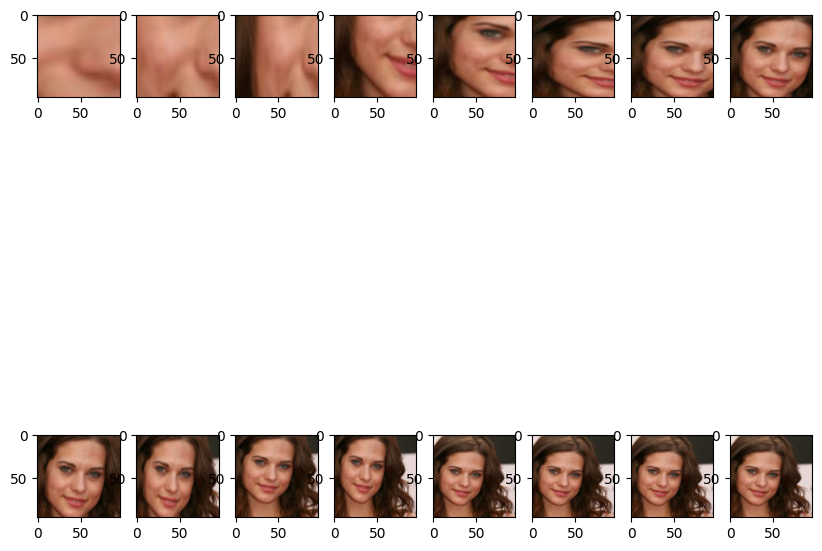

In [47]:
fig = plt.figure(figsize=(10, 10))

# img_raw1 = Image.open('assets/115.png').convert('RGB')
# img_raw2 = Image.open('assets/120.png').convert('RGB')
glimpse_size = 16
img_raw_list = []
for g in range(glimpse_size):
    img_raw_list.append(Image.open('assets/save_glimpses/img_3_glimpse_{}.png'.format(g)))

# for i in range(len(img_raw_list)):
#     print(img_raw_list[i])
for r in range(2):
    for c in range(8):
        fig.add_subplot(2, 8, 8*r+c+1)       
        plt.imshow(img_raw_list[8*r+c])
plt.show()
# print('\t Glimpse_1\t\t\t\t\t\t\t Glimpse_2')

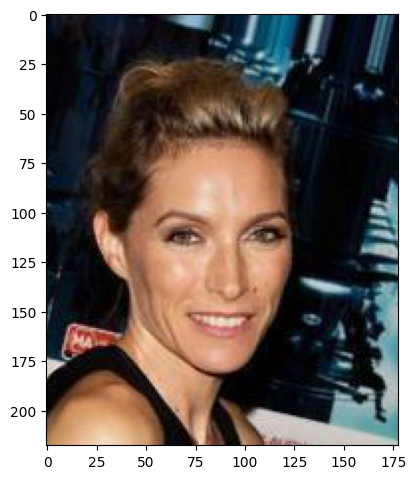

In [8]:
fig = plt.figure(figsize=(10, 10))

# img_raw = Image.open('assets/image_72602_aligned_orig.png').convert('RGB')
img_raw = Image.open('assets/image_16698_aligned_orig.png')
# img_raw_wrong = Image.open('/home/nano01/a/tao88/1.30/wrong_orig.jpg')

fig.add_subplot(1, 2, 1)
plt.imshow(img_raw)
# fig.add_subplot(1, 2, 2)
# plt.imshow(img_raw_wrong)
plt.show()

In [49]:
import pdb
to_tensor = transforms.ToTensor()
resize = transforms.Resize((256, 256))
lbl_list = []
for g in range(glimpse_size):
    img = to_tensor(img_raw_list[g])[None, :]
    img = resize(img)
    out = model(img)
    out = F.normalize(out, dim=1, p=2)
    prb = compute_dist(out, classifier)
    lbl = prb.topk(1, dim=1)[1]
    lbl = lbl.squeeze(0).squeeze(0)
    lbl_list.append(lbl)

In [9]:
to_tensor = transforms.ToTensor()

img = to_tensor(img_raw)[None, :]
out = model(img)
out = F.normalize(out, dim=1, p=2)
print(out.shape)
prb = compute_dist(out, classifier)
lbl = prb.topk(1, dim=1)[1]
lbl = lbl.squeeze(0).squeeze(0)
print(lbl.shape)

torch.Size([1, 128, 55, 45])
torch.Size([55, 45])


In [67]:
to_tensor = transforms.ToTensor()

img_wrong = to_tensor(img_raw_wrong)[None, :]
out = model(img_wrong)
out = F.normalize(out, dim=1, p=2)
prb = compute_dist(out, classifier)
lbl_wrong = prb.topk(1, dim=1)[1]
lbl_wrong = lbl_wrong.squeeze(0).squeeze(0)
print(lbl_wrong.shape)

torch.Size([64, 64])


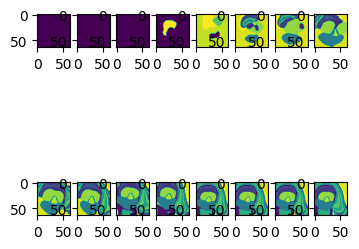

In [51]:
from matplotlib import colors

fig = plt.figure(figsize=(4, 4))
for r in range(2):
    for c in range(8):
        fig.add_subplot(2, 8, 8*r+c+1)       
        # plt.imshow(mapper_train(lbl_list[8*r+c]))
        plt.imshow(lbl_list[8*r+c])
plt.show()

# print('\t Glimpse_1 \t\t\t\t\t\t\t Glimpse_2')

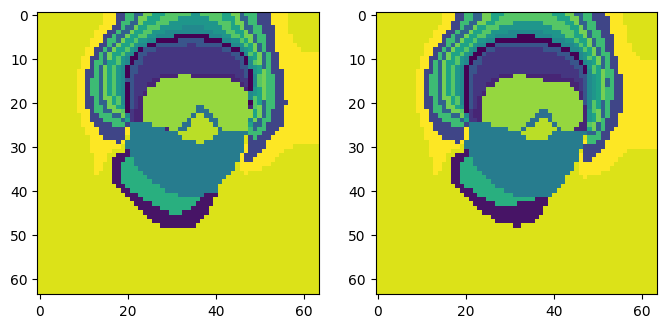

In [69]:
from matplotlib import colors

fig = plt.figure(figsize=(8, 16))
fig.add_subplot(1, 2, 1)       
# plt.imshow(mapper_train(lbl))
plt.imshow(lbl)
fig.add_subplot(1, 2, 2)       
plt.imshow(lbl_wrong)
plt.show()

As seen above, our model is able to group semantically consistent pixeles.

# 5. Visualize the nearest neighbors. 

We further investigate by looking at the nearest neighbors from the validation set of COCO dataset. First, pick a query position on each image. They are *Animal* and *Building* classes, respectively.

NameError: name 'img_raw1' is not defined

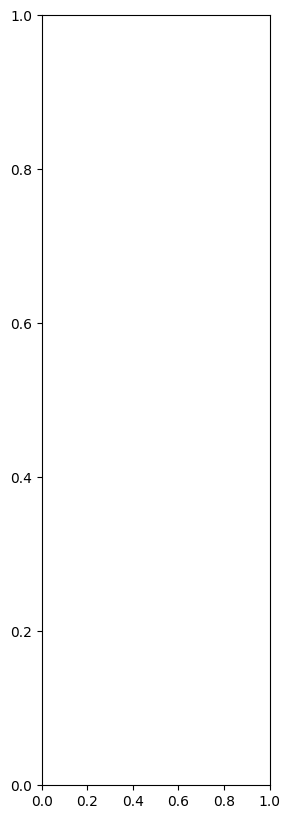

In [11]:
from matplotlib.patches import Rectangle 

fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(img_raw1)
ax = plt.gca()

# w, h
pos1  = (150, 50)
rect1 = Rectangle(pos1, 5, 5, linewidth=5, edgecolor='r', facecolor='none')
ax.add_patch(rect1)

fig.add_subplot(1, 3, 3)
plt.imshow(img_raw2)
ax = plt.gca()

# w, h
pos2  = (80, 120)
rect2 = Rectangle(pos2, 5, 5, linewidth=5, edgecolor='r', facecolor='none')
ax.add_patch(rect2)
plt.show()
print('\t Animal\t\t\t\t\t\tBuilding')

The feature maps are down-sized as below.

In [ ]:
print('Image 1 shape       : ', img_raw1.size[::-1])
print('Feature map 1 shape : ', lbl1.numpy().shape)
print('Image 2 shape       : ', img_raw2.size[::-1])
print('Feature map 2 shape : ', lbl2.numpy().shape)

Image 1 shape       :  (217, 289)
Feature map 1 shape :  (55, 73)
Image 2 shape       :  (217, 144)
Feature map 2 shape :  (55, 36)


We extract the pixel-level feature for each query and save. 

In [ ]:
# h, w
fpos1 = (pos1[1]*55//217, pos1[0]*73//289)
fpos2 = (pos2[1]*55//217, pos2[0]*36//144)

query1 = out1[:, :, fpos1[0], fpos1[1]]
query2 = out2[:, :, fpos2[0], fpos2[1]]
querys = torch.cat([query1, query2])

print('Image 1 query position : ', fpos1)
print('Image 2 query position : ', fpos2)

Image 1 query position :  (12, 37)
Image 2 query position :  (30, 20)


In [ ]:
# Save queries.
# np.save('querys.npy', querys.detach().numpy())

Now, we will look for the 5-nearest neighbors for each of these queries. The command below will retrieve the nearest neighbors of each query from the validation set of COCO images.

In [ ]:
# Run below.
# python retrieval.py --data_root datasets/coco --save_root . --stuff --thing --val_type val --K_test 5 --eval_path "picie.pkl"

In [ ]:
imglist, loclist = torch.load('picie_retrieval_result_coco.pkl')





							Animal


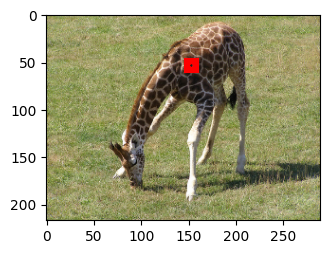

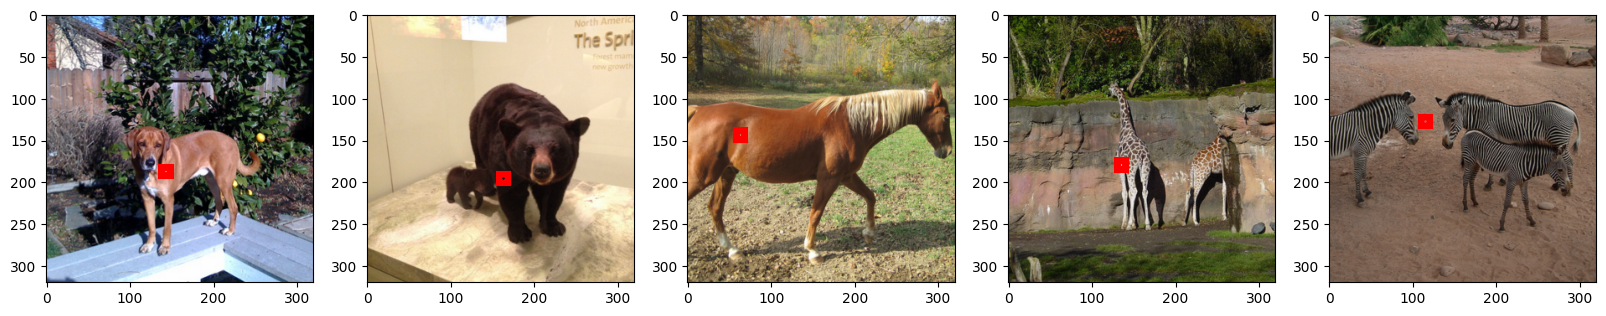





							Building


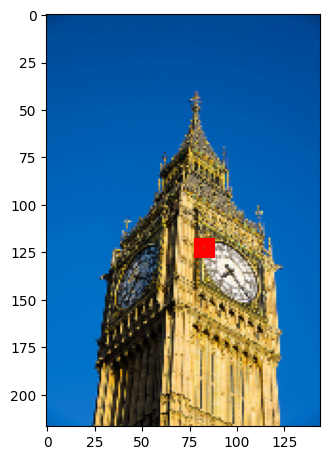

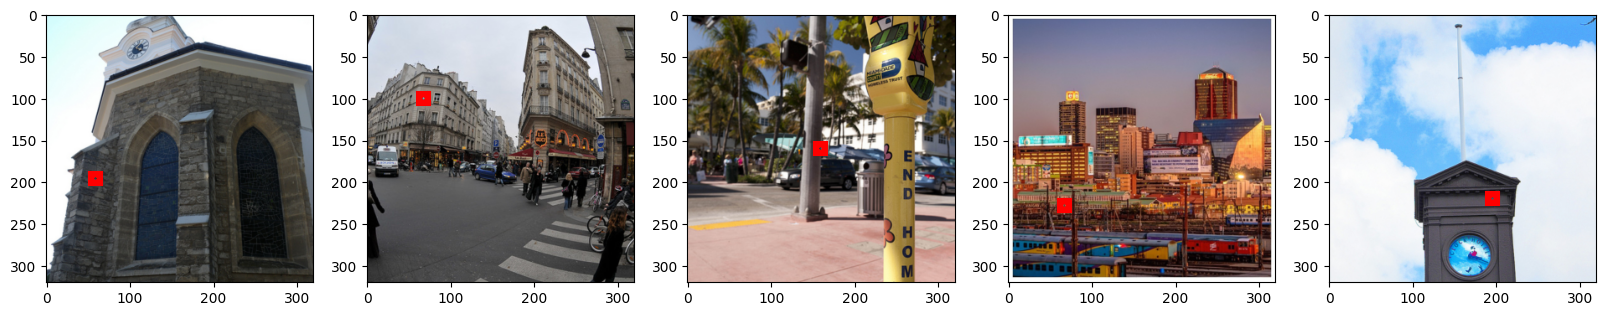

In [ ]:
def show_neighbors(img_raw, q_loc, imglist_c, loclist_c):
    fig = plt.figure(figsize=(12, 12))
    fig.add_subplot(1, 3, 2)
    plt.imshow(img_raw)
    ax = plt.gca()

    rect = Rectangle(q_loc, 5, 5, linewidth=8, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

    fig = plt.figure(figsize=(20, 100))
    for i, (img, loc) in enumerate(zip(imglist_c, loclist_c)):
        fig.add_subplot(1, 5, i+1)
        plt.imshow(img)
        ax = plt.gca()

        _, h, w = loc
        rect = Rectangle((4*w, 4*h), 5, 5, linewidth=8, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

print('\n\n\n')
print('\t\t\t\t\t\t\tAnimal')
show_neighbors(img_raw1, pos1, imglist[0], loclist[0])
print('\n\n\n')
print('\t\t\t\t\t\t\tBuilding')
show_neighbors(img_raw2, pos2, imglist[1], loclist[1])

Both *Animal* and *Building* have semantically consistent nearest neighbors. 